### MNIST torch stuff

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
## load mnist dataset

root = 'data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_set[0][0].size()

torch.Size([1, 28, 28])

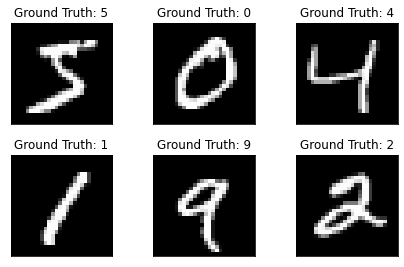

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_set[i][1]))
    plt.xticks([])
    plt.yticks([])

In [7]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2),
            nn.ReLU(),
            nn.Conv2d(64, 10, 2, 2)
        )

    def forward(self, x):
        out = self.net(x).view(x.size(0), -1)
        return out

In [8]:
target_network = MNISTConvNet()
pytorch_total_params = sum(p.numel() for p in target_network.parameters() if p.requires_grad)
pytorch_total_params

77066

### Hypernetwork

In [15]:
from hypernn.torch.hypernet import TorchHyperNetwork
from hypernn.torch.weight_generator import TorchWeightGenerator
from hypernn.torch.embedding_module import TorchEmbeddingModule
from typing import Any, Optional

In [39]:
class StaticEmbeddingModule(TorchEmbeddingModule):
    def __init__(self, embedding_dim: int, num_embeddings: int, target_input_shape: Optional[Any] = None):
        super().__init__(embedding_dim, num_embeddings)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, inp: Optional[Any] = None):
        indices = torch.arange(self.num_embeddings).to(self.device)
        return self.embedding(indices), {}


class StaticWeightGenerator(TorchWeightGenerator):
    def __init__(self, embedding_dim: int, num_embeddings: int, hidden_dim: int, target_input_shape: Optional[Any] = None):
        super().__init__(embedding_dim, num_embeddings, hidden_dim, target_input_shape)
        self.embedding_network = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.Tanh(),
            nn.Linear(32, hidden_dim, bias=False),
        )

    def forward(self, embedding: torch.Tensor, inp: Optional[Any] = None) -> torch.Tensor:
        return self.embedding_network(embedding).view(-1), {}


In [40]:
hypernetwork = TorchHyperNetwork.from_target(target_network, embedding_module=StaticEmbeddingModule, weight_generator=StaticWeightGenerator, embedding_dim=4, num_embeddings=1024)

In [41]:
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

6692

In [42]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

In [43]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

In [45]:
import tqdm
import numpy as np

optimizer = optim.Adam(hypernetwork.parameters(), lr=0.0002)
bar = tqdm.tqdm(np.arange(1000))

for i in bar:

    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        loss =  F.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        count += x.size(0)
        with torch.no_grad():
            out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
            _, predicted = torch.max(out.detach(), -1)
        num_correct += (predicted.detach().cpu() == target.data).sum()
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


Loss: 0.0701263304039836, Test Acc: 0.9715999960899353:   9%|▌      | 89/1000 [15:31<2:38:52, 10.46s/it]


KeyboardInterrupt: 

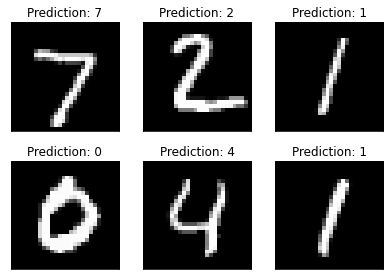

In [55]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    out = hypernetwork(inp=[test_set[i][0].to(hypernetwork.device)], has_aux=False)
    _, predicted = torch.max(out.detach(), -1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(predicted.item()))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()